In [1]:
bodensee_area = [48.00, 8.54, 47.29, 10.17] # Bodensee
europe_area= [60., -11., 34., 35.] # Europe

In [2]:
# CDS API helper

import cdsapi
import hashlib
import os

cds_data_dir = "data/cds"
temp_dir = "data/temp"

# You'll have to provide an API key for the CDS api.
# You can set this in a global configuration file, like described in the cdsapi documentation.
# Alternatively, set it right here in the notebook
cds_url = "https://cds.climate.copernicus.eu/api/v2"
cds_key = None
# cds_key = "000000:aaaaaaaa-bbbb-cccc-9999-0123456789ab"

class CDS_Dataset():
    '''
    Thin wrapper around CDS Python API for caching datasets locally.
    '''
    
    def __init__(self, topic, config):
        self.topic = topic
        self.config = config

    def path(self):
        h = hashlib.new('SHA256')
        h.update(self.topic.encode('utf-8'))
        for k, v in sorted(self.config.items()):
            h.update(f'|{k}:{v}'.encode('utf-8'))
        fingerprint = h.hexdigest()[:16]
        return f"{cds_data_dir}/dataset_{fingerprint}.{self.config["format"]}"

    def retrieve(self):
        os.makedirs(cds_data_dir, exist_ok=True)
        if cds_key is not None:
            cdsc = cdsapi.Client(url = cds_url, key = cds_key)
        else:
            cdsc = cdsapi.Client()
        cdsc.retrieve(self.topic, self.config, self.path())

    def is_local(self):
        return os.path.exists(self.path())

    def load(self):
        if not self.is_local():
            self.retrieve()

        return self.path()

# CDS_dataset usage example

dataset = CDS_Dataset(
    'satellite-lake-water-temperature', {
        'variable': 'all',
        'format': 'zip',
        'version': '4.5.2',
        'year': '2022',
        'month': [ f"{x:02d}" for x in range(1, 13) ],
        'day': [ f"{x:02d}" for x in range(1, 32) ],
        'area': bodensee_area
    })

dataset.load()

'data/cds/dataset_39f356db72d96f20.zip'

In [3]:
# Lake Water Surface Temperature
# https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-lake-water-temperature

import shutil
import tempfile
import xarray
import zipfile

class SatelliteLakeWaterTemperature():
    '''
    Wrapper for CDS Python API simplifing access to the satellite-lake-water-temperatur dataset.
    '''
    
    def __init__(self, area, years):
        self.topic = 'satellite-lake-water-temperature'
        self.area = area
        self.years = years
        self.nc_dir = None

    def cds_dataset_year(self, year):
        config = dict(
            variable = 'all',
            format = 'zip',
            version = '4.5.1' if year <= 2020 else '4.5.2',
            year = year,
            month = [ f"{x:02d}" for x in range(1, 13) ],
            day = [ f"{x:02d}" for x in range(1, 32) ],
            area = self.area,
        )
        return CDS_Dataset(self.topic, config)

    def load(self):
        datasets = [ self.cds_dataset_year(y) for y in self.years ]
        local = sum([d.is_local() for d in datasets])
        if local < len(datasets):
            print(f"{local} of {len(datasets)} datasets are available locally.")
            print(f"{len(datasets) - local} will now be downloaded from CDS.")
        if local < len(datasets):
            print("get remaining datasets from CDS ...")
        return [ d.load() for d in datasets ]

    def unzip(self):
        if self.nc_dir is None:
            self.nc_dir = tempfile.mkdtemp(prefix="cds-" + self.topic + "-")
            
            for path in self.load():  
                with zipfile.ZipFile(path,"r") as f:
                    f.extractall(self.nc_dir)
                    
        return [ e.path for e in os.scandir(self.nc_dir) if e.path.endswith(".nc") ]

    def xarray(self):
        nc_files = self.unzip()
        nc_files = sorted(nc_files)
        return xarray.open_mfdataset(nc_files)

    def free(self):
        if self.nc_dir is not None:
            shutil.rmtree(self.nc_dir)
        

    def __del__(self):
        # self.free()
        pass

# SatelliteLakeWaterTemperature usage example
# -------------------------------------------
# This works with `years = range(1995, 2024)` but downloading the 29 datasets will take a couple of hours!
# This loads everything into a combined xarray
# Some operations on that xarray will eat > 16GB RAM, thus we later operate on the individual netcdf files

slwt = SatelliteLakeWaterTemperature(bodensee_area, years = [2022, 2023])

zip_files = slwt.load() # access CDS API or reuse local cache
display(zip_files)

netcdf_files = slwt.unzip() # extract zip_files, list the resulting netcdf files
display(netcdf_files[:3]) # only the first 3

xarray_dataset = slwt.xarray() # combine all netcdf into a single xarray dataset
display(xarray_dataset)

['data/cds/dataset_39f356db72d96f20.zip',
 'data/cds/dataset_418c5989d367775c.zip']

['/tmp/cds-satellite-lake-water-temperature-woss5yis/e38ffa54-fcc6-42b3-b78e-686cba4afbd2-20220115120000-EOCIS-L3S-LSWT-4_area_subset.nc',
 '/tmp/cds-satellite-lake-water-temperature-woss5yis/e38ffa54-fcc6-42b3-b78e-686cba4afbd2-20221121120000-EOCIS-L3S-LSWT-4_area_subset.nc',
 '/tmp/cds-satellite-lake-water-temperature-woss5yis/e38ffa54-fcc6-42b3-b78e-686cba4afbd2-20220325120000-EOCIS-L3S-LSWT-4_area_subset.nc']

<xarray.Dataset> Size: 12MB
Dimensions:                         (time: 730, lat: 14, lon: 32)
Coordinates:
  * lat                             (lat) float32 56B 47.33 47.38 ... 47.97
  * lon                             (lon) float32 128B 8.575 8.625 ... 10.12
  * time                            (time) datetime64[ns] 6kB 2022-01-01T12:0...
Data variables:
    lake_surface_water_temperature  (time, lat, lon) float32 1MB dask.array<chunksize=(1, 14, 32), meta=np.ndarray>
    lswt_uncertainty                (time, lat, lon) float32 1MB dask.array<chunksize=(1, 14, 32), meta=np.ndarray>
    lswt_quality_level              (time, lat, lon) float32 1MB dask.array<chunksize=(1, 14, 32), meta=np.ndarray>
    lswt_obs_instr                  (time, lat, lon) float32 1MB dask.array<chunksize=(1, 14, 32), meta=np.ndarray>
    lswt_flag_bias_correction       (time, lat, lon) float32 1MB dask.array<chunksize=(1, 14, 32), meta=np.ndarray>
    lakeid_CCI                      (time, lat, lon) float64 3MB dask.array<chunksize=(1, 14, 32), meta=np.ndarray>
    lakeid_GloboLakes               (time, lat, lon) float64 3MB dask.array<chunksize=(1, 14, 32), meta=np.ndarray>
Attributes: (12/51)
    title:                           UK Earth Observation Climate Information...
    institution:                     EOCIS, University of Reading
    summary:                         L3S product from the ESA CCI project: LS...
    citation:                        Carrea, L., Crétaux, J.-F., Liu, X., Wu,...
    licence:                         Creative Commons Attribution 4.0 Interna...
    reference:                       https://cds.climate.copernicus.eu
    ...                              ...
    easternmost_longitude:           180.0
    westernmost_longitude:           -180.0
    processing_level:                L3S
    cdm_data_type:                   grid
    source_file:                     20220101120000-ESACCI-L3C_GHRSST-MODIS_T...
    source_file_path:                /gws/nopw/j04/nceo_uor/users/lcarrea01/O...

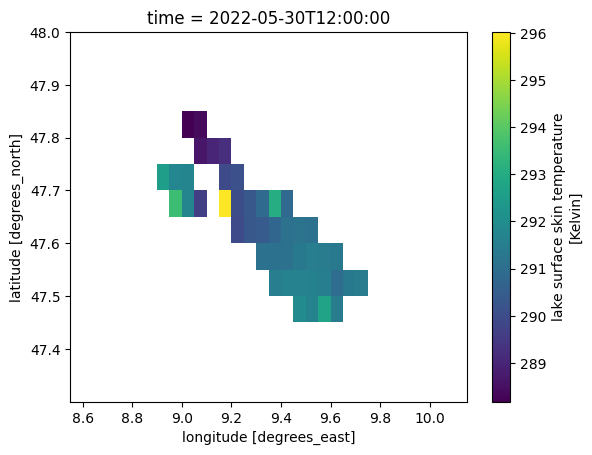

/home/patrik/devel/sgc-cds-examples/venv/lib64/python3.12/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


In [4]:
xarray_dataset.sel(time='2022-05-30T12:00')['lake_surface_water_temperature'].plot()

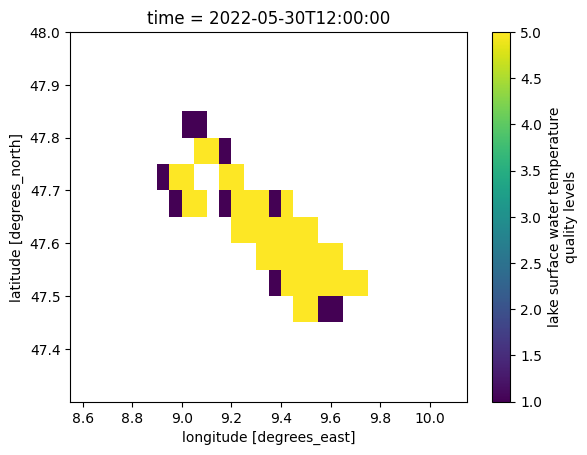

In [5]:
xarray_dataset.sel(time='2022-05-30T12:00')['lswt_quality_level'].plot()

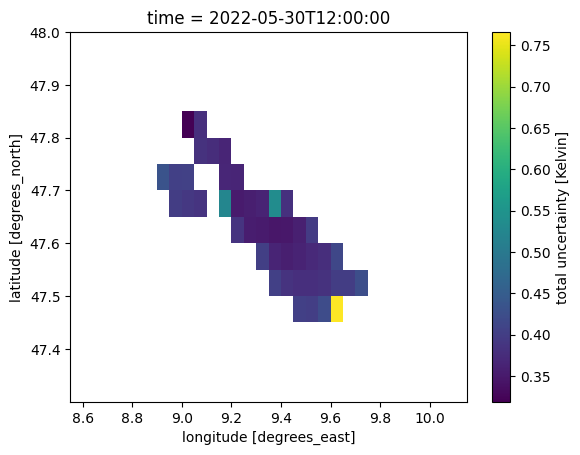

In [6]:
xarray_dataset.sel(time='2022-05-30T12:00')['lswt_uncertainty'].plot()

/home/patrik/devel/sgc-cds-examples/venv/lib64/python3.12/site-packages/xarray/plot/utils.py:245: RuntimeWarning: overflow encountered in scalar absolute
  vlim = max(abs(vmin - center), abs(vmax - center))


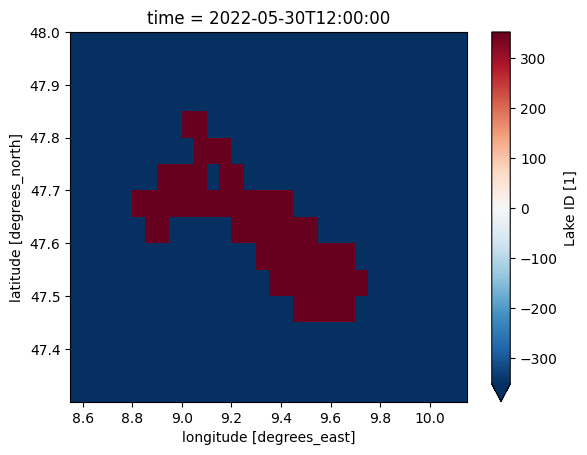

In [7]:
xarray_dataset.sel(time='2022-05-30T12:00')['lakeid_CCI'].astype('int').plot()

---

The CDS dataset has a variable linking to lake dataset.
We quickly show how to access this dataset.
We will later filter for Lake Constance / Bodensee.
You probably want to pick a different lake.

In [8]:
# CCI lake ids
# Source: https://zenodo.org/records/6699376

import pandas

cci_lakes_url = "https://zenodo.org/records/6699376/files/ESA_CCI_static_lake_mask_v2_1km_UoR_metadata_fv2.1_06Oct2021.csv?download=1"
cci_lakes = pandas.read_csv(cci_lakes_url).set_index('CCI ID')

# Bodensee has id 352
bodensee = 352
cci_lakes.loc[bodensee]

NAME                              Constance lake/Bodensee
COUNTRY                       Austria;Switzerland;Germany
MAX DISTANCE TO LAND (KM)                             6.0
LAT CENTRE                                        47.5431
LON CENTRE                                         9.5097
LAT MIN BOX                                       47.4375
LAT MAX BOX                                       47.8542
LON MIN BOX                                        8.7958
LON MAX BOX                                        9.7875
ID in GLOBOLAKES 1000 MASK                           352;
ID in CGLOPS MASK                                    352;
Name: 352, dtype: object

---

We want to extract a timeseries for the mean surface lake temperature for individual lakes.
On the combined xarray dataset the operation would look like this:

```python
# subset the dataset; restrict to lake = Bodensee
ts = (
    xarray_dataset
    .where(xarray_dataset['lakeid_CCI'] == float(bodensee))
    ['lake_surface_water_temperature']
    .groupby('time')
    .mean(['lat', 'lon'])
)
ts.plot()
```
This works for a couple (3 at least) years on my notebook. For the full history (29 years) we run out of memory.
The work-around is to iterate the netcdf files individually.

In [9]:
from tqdm import tqdm

slwt = SatelliteLakeWaterTemperature(bodensee_area, years = range(1995, 2024))
path = slwt.unzip()[0]
dataframes = []
for path in tqdm(slwt.unzip()):
    ds = xarray.open_dataset(path)
    df = (
        ds
        .where(ds['lakeid_CCI'] == bodensee)
        .where(ds['lswt_quality_level'] >= 4) # only good and best quality
        [['lake_surface_water_temperature', 'lswt_uncertainty', 'lswt_quality_level', 'lakeid_CCI', 'lakeid_GloboLakes']]
        .groupby('time')
        .mean(['lat', 'lon'])
        .to_pandas()
    )
    dataframes.append(df)

100%|█████████████████████████████████████| 10213/10213 [02:19<00:00, 73.24it/s]


In [10]:
# build combined dataframe
df = pandas.concat(dataframes).sort_index() 
# remove points w/o measurement
df = df[df.lake_surface_water_temperature.notna()]
# convert id to integer
df.lakeid_CCI = df.lakeid_CCI.map(int)
df.lakeid_GloboLakes = df.lakeid_GloboLakes.map(int)
df

,lake_surface_water_temperature,lswt_uncertainty,lswt_quality_level,lakeid_CCI,lakeid_GloboLakes
time,,,,,
1995-06-02 12:00:00,287.470001,0.458750,4.000000,352,352
1995-06-08 12:00:00,289.205994,0.472800,4.300000,352,352
1995-06-27 12:00:00,291.587494,0.389917,4.250000,352,352
1995-06-30 12:00:00,293.439026,0.246548,4.870968,352,352
1995-07-07 12:00:00,293.743317,0.421222,4.944445,352,352
...,...,...,...,...,...
2023-12-15 12:00:00,279.478973,0.292100,4.800000,352,352
2023-12-16 12:00:00,280.106140,0.209923,4.961538,352,352
2023-12-19 12:00:00,278.544983,0.209000,5.000000,352,352


<Axes: xlabel='time'>

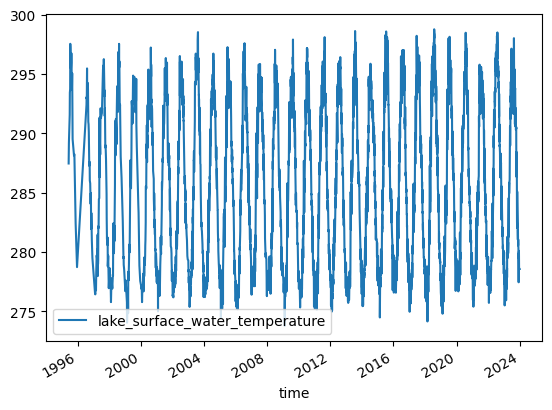

In [11]:
df.plot(y='lake_surface_water_temperature')

In [12]:
df.to_csv('satellite-lake-water-temperature.csv', sep=',', encoding='utf-8')